In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import functional
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.io import read_image
from torchvision.io import read_image

1) Выбрать задачу по классификации изображений, загрузить данные,
провести анализ (распределение классов, особенности данных и т.д.) -
2 балла

Мною была выбрана задача классификации птиц: https: .kaggle.com/competitions/sp23-bird-classif-cation-osu-ai-cl-ub/

In [2]:
 # Для проверки будет удобно записать в переменную path свой path - код будет работать
path = '/media/egor/Windows/Users/Egor/Documents/Files/Учёба/ML_and_DL_Digital_department/3_Lab/'
df = pd.read_csv(f'{path}birds.csv')
df

,image_id,class_id,filepaths,labels,scientific_label,data_set
0,0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train
1,1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train
2,2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train
3,3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train
4,4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train
...,...,...,...,...,...,...
72871,72871,449,valid/YELLOW HEADED BLACKBIRD/1.jpg,YELLOW HEADED BLACKBIRD,Xanthocephalus,valid
72872,72872,449,valid/YELLOW HEADED BLACKBIRD/2.jpg,YELLOW HEADED BLACKBIRD,Xanthocephalus,valid
72873,72873,449,valid/YELLOW HEADED BLACKBIRD/3.jpg,YELLOW HEADED BLACKBIRD,Xanthocephalus,valid
72874,72874,449,valid/YELLOW HEADED BLACKBIRD/4.jpg,YELLOW HEADED BLACKBIRD,Xanthocephalus,valid


In [12]:
df['class_id'] = df['class_id'].apply(str)
df_train = df[df['data_set'] == 'train']
df_valid = df[df['data_set'] == 'valid']
print(df['class_id'].describe())
print(df_train['class_id'].describe())
print(df_valid['class_id'].describe())

count     72876
unique      450
top         262
freq        253
Name: class_id, dtype: object
count     70626
unique      450
top         262
freq        248
Name: class_id, dtype: object
count     2250
unique     450
top        304
freq         5
Name: class_id, dtype: object


In [13]:
print(df['labels'].describe())
print(df_train['labels'].describe())
print(df_valid['labels'].describe())
# Видим, что class_id и labels совпадают - с датасетом всё хорошо.

count           72876
unique            450
top       HOUSE FINCH
freq              253
Name: labels, dtype: object
count           70626
unique            450
top       HOUSE FINCH
freq              248
Name: labels, dtype: object
count     2250
unique     450
top       MYNA
freq         5
Name: labels, dtype: object


In [14]:
df['scientific_label'].describe()
# У нас 447 видов птиц (по видимому есть несколько морф, которые относятся к одному виду),
# самый распостранённый класс Александров кольчатый попугай (зелёненький такой)
# У него 354 изображения, что составляет ~0,5%,
# что в ~2 раза больше, чем среднее количество фотографий 72676/447 = 163 на класс.
# Тем не менее, т.к. у нас очень много классов, то можно считать датасет сбалансированным по классам.
# Т.к. превышение 1 класса из 447 в 2 раза выше среднего - не является чем-то критичным.

count                   72876
unique                    447
top       Psittacula eupatria
freq                      354
Name: scientific_label, dtype: object

In [15]:
df['data_set'].describe()
# Видим, что 97% набора являются тренирововчным, и только 3 отданы на валидацию.

count     72876
unique        2
top       train
freq      70626
Name: data_set, dtype: object

In [4]:
df_test = pd.read_csv(f'{path}sample_solution.csv')
df_test

,image_id,class_id
0,72876,427
1,72877,188
2,72878,142
3,72879,413
4,72880,371
...,...,...
2245,75121,167
2246,75122,373
2247,75123,277
2248,75124,126


In [5]:
df_test['class_id'] = df_test['class_id'].apply(str)
df_test['class_id'].describe()
# В папке test находится ~3% от общего количества изображений
# Из 450 классов тренировочного набора присутствует 445 классов,
# т.е. 5 классов не предствалены в тестовом наборе

count     2250
unique     445
top        318
freq        12
Name: class_id, dtype: object

2) Написать класс для датасета, наследуемый от PyTorch Dataset, в
котором реализовать init, len, getitem методы - 3 балла

In [23]:
class Birds(Dataset):
    
    def __init__(self, path, annotation, transform = None, target_transform = None):
        self.img_labels = annotation['image_id']
        self.img_class = annotation['class_id']
        self.data_dir = path
        self.img_dir = annotation['filepaths']
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = str(self.data_dir + self.img_dir[idx])
        image = read_image(img_path)
        label = self.img_class.loc[idx] 
        #label = self.img_class[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    

3) Поместить датасет в dataloader, разбив на батчи - 3 балла

In [4]:
# Т.к. оказалось, не все изображения данного размера
transform = Compose([Resize((224, 224))])

df['class_id'] = df['class_id'].apply(int)
df_train = df[df['data_set'] == 'train']
df_valid = df[df['data_set'] == 'valid']
# Без реиндексации DataLoader не может использовать метод get_item
df_valid.reset_index(drop=True, inplace=True)

train_data = Birds(path, df_train, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=100, shuffle=True, drop_last=True)
valid_data = Birds(path, df_valid, transform=transform)
valid_dataloader = DataLoader(valid_data, batch_size=100, shuffle=False, drop_last=True)

In [102]:
# Выбор одного случайного изображения
for img, label in train_dataloader:
    break
print(img.shape)
print(img[0].shape)
# Переворачиваем порядок измерений из (channels, height, width) в (height, width, channels)
img = img[0].permute(1, 2, 0)
print(type(img))
# Преобразуем тензор в массив numpy
img_np = img.numpy()
img = (img * 255).byte()
print(type(img_np))
# Создаем изображение с помощью PIL
img_pil = Image.fromarray(img_np)
print(type(img_pil))

#img_pil.show()
# Изначальный размер изображения batch*3*224*224
for img, label in valid_dataloader:
    break
print(img.shape)

torch.Size([100, 3, 224, 224])
torch.Size([3, 224, 224])
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'PIL.Image.Image'>
torch.Size([100, 3, 224, 224])


4) Обучить модель, состоящую из полносвязных слоёв или обучить модель,
состоящую из сверточных и полносвязных слоев (например, Conv -
Pooling - Conv - Linear - Linear) - 5 баллов

Решил попробовать немного другую архитектуру:
Conv - Pooling - Conv - Pooling - Conv - Pooling - Linear - Linear

In [21]:
class MyFirstArchiectureNN(nn.Module):
    # Изначально мой батч размерности batch*3*224*224
    def __init__(self):
        super(MyFirstArchiectureNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=1)
        # Теперь он свёрнут до batch*6*222*222
        self.pool1 = nn.MaxPool2d(3, stride=2)
        # Pooling уменьшил размерность в 2 раза batch*6*110*110
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=10, stride=1, padding=1)
        # Теперь он свёрнут до batch*12*103*103
        self.pool2 = nn.MaxPool2d(2, stride=3)
        # Теперь он свёрнут до batch*12*51*51
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=20, stride=1, padding=1)
        # Теперь он свёрнут до batch*24*34*34
        self.pool3 = nn.MaxPool2d(2, stride=3)
        
        self.linear1 = nn.Linear(24*6*6, 512)
        # Теперь свёрнут до 1*
        self.linear2 = nn.Linear(512, 450)
        #Сворачиваем до 450 (сколько целевых классов)

    def forward(self, input):
        output = F.relu(self.conv1(input))
        #print(output.shape)
        output = self.pool1(output)
        #print(output.shape)
        output = F.relu(self.conv2(output))
        #print(output.shape)
        output = self.pool2(output)
        #print(output.shape)
        output = F.relu(self.conv3(output))
        #print(output.shape)
        output = self.pool3(output)
        #print(output.shape)
        output = output.view(output.size(0), 24*6*6)
        output = F.relu(self.linear1(output))
        #print(output.shape)
        output = self.linear2(output)
        #print(output.shape)
        #print('Forward finished')
        return output

In [15]:
device_count = torch.cuda.device_count()
print(f"Доступно устройств GPU: {device_count}")

for i in range(device_count):
    device_name = torch.cuda.get_device_name(i)
    print(f"Устройство {i}: {device_name}")

# Определяем устройство для обучения
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

Доступно устройств GPU: 1
Устройство 0: NVIDIA GeForce RTX 3060 Laptop GPU
cuda:0


In [111]:
# Создаём объекс нашего собственного класса нейросети и закидываем на видеокарту
my_first_nn = MyFirstArchiectureNN().to(device)
# Выбираем функцию потерь (вроде как CrossEntropy хороша для задач классификации)
criterion = nn.CrossEntropyLoss().to(device)
# Выбираем оптимизатор Adam, т.к. современный и активно используется
optimizer = torch.optim.Adam(my_first_nn.parameters(), lr=0.001)

train_losses = []
valid_losses = []
num_epochs = 10 # Для пробы взял немного эпох

#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=5'
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

for epoch in range(num_epochs):
    train_loss = 0.0
    for batch, labels in train_dataloader:
        #print(batch.shape)
        #print(labels.shape)
        # Закидываем наши данные на видеокарту
        batch, labels = batch.to(device), labels.to(device)
        my_first_nn.train()
        batch = batch.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = my_first_nn(batch.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss = {loss.item():.4f}')
    
    my_first_nn.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch, labels in valid_dataloader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = my_first_nn(batch.float())
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    print(f'Valid loss = {loss.item():.4f}')
    
    train_losses.append(train_loss / len(train_dataloader))
    valid_losses.append(valid_loss / len(valid_dataloader))
    
print('Training is finished')

torch.save(my_first_nn.state_dict(), 'my_first_bird_classifier.pth')
combined_list = list(zip(train_losses, valid_losses))
losses = pd.DataFrame(combined_list, columns=['train_loss', 'valid_loss'])
losses.to_csv('Losses_10_epoch.csv', index=False)

Epoch [1/10], Loss = 4.8150
Valid loss = 4.4078
Epoch [2/10], Loss = 4.5833
Valid loss = 3.7284
Epoch [3/10], Loss = 3.5935
Valid loss = 3.4882
Epoch [4/10], Loss = 3.5656
Valid loss = 3.3240
Epoch [5/10], Loss = 3.3632
Valid loss = 3.5474
Epoch [6/10], Loss = 2.5787
Valid loss = 3.6479
Epoch [7/10], Loss = 2.5133
Valid loss = 4.0713
Epoch [8/10], Loss = 2.2098
Valid loss = 4.2945
Epoch [9/10], Loss = 2.3371
Valid loss = 4.7086
Epoch [10/10], Loss = 1.8018
Valid loss = 4.7451
Training is finished


In [113]:
losses

,train_loss,valid_loss
0,5.335851,4.709277
1,4.545693,4.071092
2,4.003162,3.857585
3,3.541679,3.794575
4,3.118787,3.757665
5,2.772560,4.014781
6,2.432213,4.409506
7,2.146215,4.524941
8,1.911599,4.991146
9,1.704712,5.636702


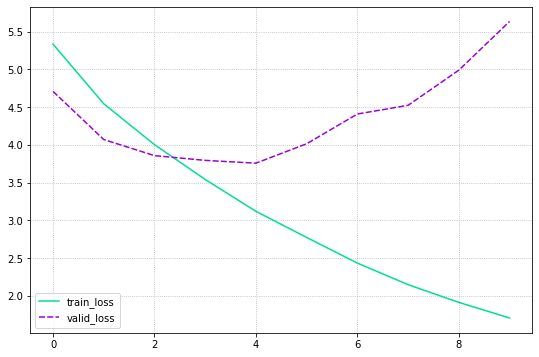

In [123]:
f = plt.figure(figsize = (9, 6))
colors = ['#00DD99', '#9900DD']
sns.lineplot(data=losses, palette = colors)
plt.grid(ls = ':')
plt.show()
# По графику ясно видно, что мы переобучили нейросеть.
# Для данной архитектуры должно хватить 5 эпох 

##### Заново обучим модель, но только 5 эпох

Epoch [1/5], Loss = 4.9852
Valid loss = 4.3478
Epoch [2/5], Loss = 4.2471
Valid loss = 3.7104
Epoch [3/5], Loss = 3.5246
Valid loss = 3.2733
Epoch [4/5], Loss = 2.8272
Valid loss = 3.4031
Epoch [5/5], Loss = 2.9884
Valid loss = 3.3933
Training is finished


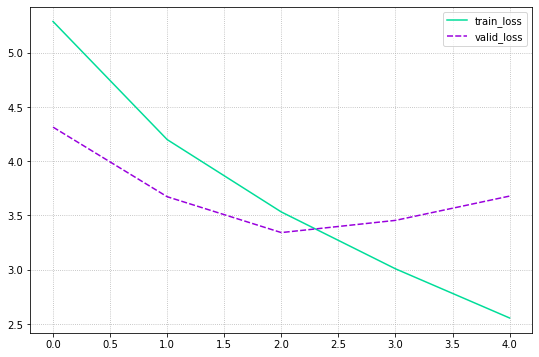

In [13]:
# Т.к. оказалось, не все изображения данного размера
transform = Compose([Resize((224, 224))])

df['class_id'] = df['class_id'].apply(int)
df_train = df[df['data_set'] == 'train']
df_valid = df[df['data_set'] == 'valid']
# Без реиндексации DataLoader не может использовать метод get_item
df_valid.reset_index(drop=True, inplace=True)

train_data = Birds(path, df_train, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=100, shuffle=True, drop_last=True)
valid_data = Birds(path, df_valid, transform=transform)
valid_dataloader = DataLoader(valid_data, batch_size=100, shuffle=False, drop_last=True)
# Создаём объекс нашего собственного класса нейросети и закидываем на видеокарту
my_first_nn = MyFirstArchiectureNN().to(device)
# Выбираем функцию потерь (вроде как CrossEntropy хороша для задач классификации)
criterion = nn.CrossEntropyLoss().to(device)
# Выбираем оптимизатор Adam, т.к. современный и активно используется
optimizer = torch.optim.Adam(my_first_nn.parameters(), lr=0.001)

train_losses = []
valid_losses = []
num_epochs = 5 # Больше эпох приводит к переобучению

for epoch in range(num_epochs):
    train_loss = 0.0
    for batch, labels in train_dataloader:
        # Закидываем наши данные на видеокарту
        batch, labels = batch.to(device), labels.to(device)
        my_first_nn.train()
        batch = batch.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = my_first_nn(batch.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss = {loss.item():.4f}')
    
    my_first_nn.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch, labels in valid_dataloader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = my_first_nn(batch.float())
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    print(f'Valid loss = {loss.item():.4f}')
    
    train_losses.append(train_loss / len(train_dataloader))
    valid_losses.append(valid_loss / len(valid_dataloader))
    
print('Training is finished')

torch.save(my_first_nn.state_dict(), 'my_first_bird_classifier_5_epoch.pth')

combined_list = list(zip(train_losses, valid_losses))
losses = pd.DataFrame(combined_list, columns=['train_loss', 'valid_loss'])
losses.to_csv('Losses_5_epoch.csv', index=False)
f = plt.figure(figsize = (9, 6))
colors = ['#00DD99', '#9900DD']
sns.lineplot(data=losses, palette = colors)
plt.grid(ls = ':')
plt.show()

# Не идеально, но что есть, то есть...

Epoch [1/3], Loss = 4.8763
Valid loss = 4.8287
Epoch [2/3], Loss = 4.2213
Valid loss = 3.8333
Epoch [3/3], Loss = 3.5894
Valid loss = 3.5270
Training is finished


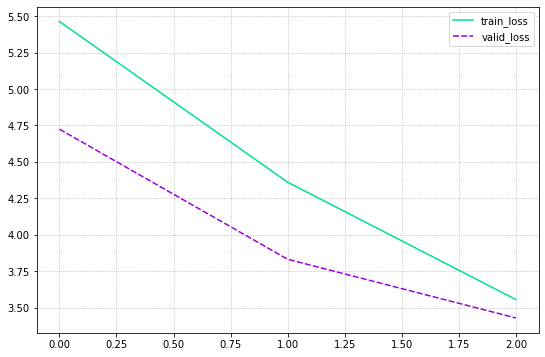

In [27]:
# Т.к. оказалось, не все изображения данного размера
transform = Compose([Resize((224, 224))])

df['class_id'] = df['class_id'].apply(int)
df_train = df[df['data_set'] == 'train']
df_valid = df[df['data_set'] == 'valid']
# Без реиндексации DataLoader не может использовать метод get_item
df_valid.reset_index(drop=True, inplace=True)

train_data = Birds(path, df_train, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=100, shuffle=True, drop_last=True)
valid_data = Birds(path, df_valid, transform=transform)
valid_dataloader = DataLoader(valid_data, batch_size=100, shuffle=False, drop_last=True)
# Создаём объекс нашего собственного класса нейросети и закидываем на видеокарту
my_first_nn = MyFirstArchiectureNN().to(device)
# Выбираем функцию потерь (вроде как CrossEntropy хороша для задач классификации)
criterion = nn.CrossEntropyLoss().to(device)
# Выбираем оптимизатор Adam, т.к. современный и активно используется
optimizer = torch.optim.Adam(my_first_nn.parameters(), lr=0.001)

train_losses = []
valid_losses = []
num_epochs = 3

for epoch in range(num_epochs):
    train_loss = 0.0
    for batch, labels in train_dataloader:
        # Закидываем наши данные на видеокарту
        batch, labels = batch.to(device), labels.to(device)
        my_first_nn.train()
        batch = batch.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = my_first_nn(batch.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss = {loss.item():.4f}')
    
    my_first_nn.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch, labels in valid_dataloader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = my_first_nn(batch.float())
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    print(f'Valid loss = {loss.item():.4f}')
    
    train_losses.append(train_loss / len(train_dataloader))
    valid_losses.append(valid_loss / len(valid_dataloader))
    
print('Training is finished')

torch.save(my_first_nn.state_dict(), 'my_first_bird_classifier_3_epoch.pth')

combined_list = list(zip(train_losses, valid_losses))
losses = pd.DataFrame(combined_list, columns=['train_loss', 'valid_loss'])
losses.to_csv('Losses_3_epoch.csv', index=False)
f = plt.figure(figsize = (9, 6))
colors = ['#00DD99', '#9900DD']
sns.lineplot(data=losses, palette = colors)
plt.grid(ls = ':')
plt.show()

In [61]:
class Birds2(Dataset):
    
    def __init__(self, path, annotation, transform = None, target_transform = None):
        self.img_labels = annotation['image_id']
        self.img_class = annotation['class_id']
        self.data_dir = path
        self.img_dir = annotation['filepaths']
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = str(self.data_dir + self.img_dir[idx])
        image = read_image(img_path)
        # Пришлось добавить, потому что далее надо подавать PIL image
        image = functional.to_pil_image(image)
        label = self.img_class.loc[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


Epoch [1/5], Loss = 4.6075
Valid loss = 4.0654
Epoch [2/5], Loss = 3.3358
Valid loss = 2.5462
Epoch [3/5], Loss = 2.4143
Valid loss = 2.4759
Epoch [4/5], Loss = 3.2351
Valid loss = 1.9141
Epoch [5/5], Loss = 2.5219
Valid loss = 2.2396
Training is finished


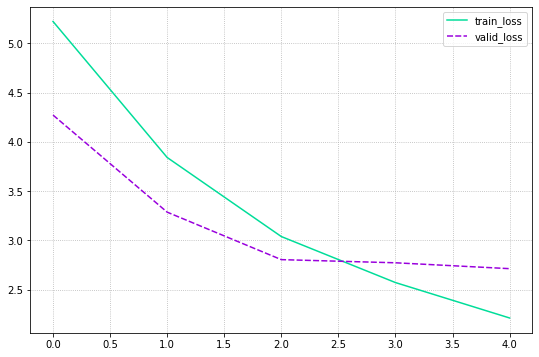

In [62]:
# Попробуем добавить нормализацию данных для наших изображений
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

df['class_id'] = df['class_id'].apply(int)
df_train = df[df['data_set'] == 'train']
df_valid = df[df['data_set'] == 'valid']
# Без реиндексации DataLoader не может использовать метод get_item
df_valid.reset_index(drop=True, inplace=True)
# Загружаем наши данные в DataLoader для подачи в нейросеть
# Прочитал, что обычно используют малые батчи ~32-64
train_data = Birds2(path, df_train, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
valid_data = Birds2(path, df_valid, transform=transform)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False, drop_last=True)
# Создаём объекс нашего собственного класса нейросети и закидываем на видеокарту
my_first_nn = MyFirstArchiectureNN().to(device)
# Выбираем функцию потерь (вроде как CrossEntropy хороша для задач классификации)
criterion = nn.CrossEntropyLoss().to(device)
# Выбираем оптимизатор Adam, т.к. современный и активно используется
optimizer = torch.optim.Adam(my_first_nn.parameters(), lr=0.001)

train_losses = []
valid_losses = []
num_epochs = 5

for epoch in range(num_epochs):
    train_loss = 0.0
    for batch, labels in train_dataloader:
        # Закидываем наши данные на видеокарту
        batch, labels = batch.to(device), labels.to(device)
        my_first_nn.train()
        batch = batch.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = my_first_nn(batch.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss = {loss.item():.4f}')
    
    my_first_nn.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch, labels in valid_dataloader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = my_first_nn(batch.float())
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    print(f'Valid loss = {loss.item():.4f}')
    
    train_losses.append(train_loss / len(train_dataloader))
    valid_losses.append(valid_loss / len(valid_dataloader))
    
print('Training is finished')

torch.save(my_first_nn.state_dict(), 'bird_classifier_5_epoch_norm.pth')

combined_list = list(zip(train_losses, valid_losses))
losses = pd.DataFrame(combined_list, columns=['train_loss', 'valid_loss'])
losses.to_csv('Losses_5_epoch_norm.csv', index=False)
f = plt.figure(figsize = (9, 6))
colors = ['#00DD99', '#9900DD']
sns.lineplot(data=losses, palette = colors)
plt.grid(ls = ':')
plt.show()
# Лучшая из моих моделей

5) Обучить или дообучить одну из моделей, включенных в torchvision
например, ResNet (модели можно посмотреть тут
https: pytorch.org/vision/stable/models.html) - 4 балла

Я кратко изучил предобученные модели по ссылке. И прочитал эту страницу: 
https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/
Я решил взять более новую модель и при этом с минимальным количеством параметров, т.к. хоть я и обучаю на GPU, но использую ноутбук.
Как итог, выбрал shufflenet_v2_x0_5 (2018 год), потому что она новее ResNet (2015) и содержит меньше параметров, чем MobileNet (2018).


In [17]:
from torchvision.models import shufflenet_v2_x0_5

Epoch [1/5], Loss = 0.7819
Valid loss = 0.5202
Epoch [2/5], Loss = 1.0344
Valid loss = 0.3856
Epoch [3/5], Loss = 0.8163
Valid loss = 0.2461
Epoch [4/5], Loss = 0.8431
Valid loss = 0.1212
Epoch [5/5], Loss = 0.4703
Valid loss = 0.3877
Training is finished


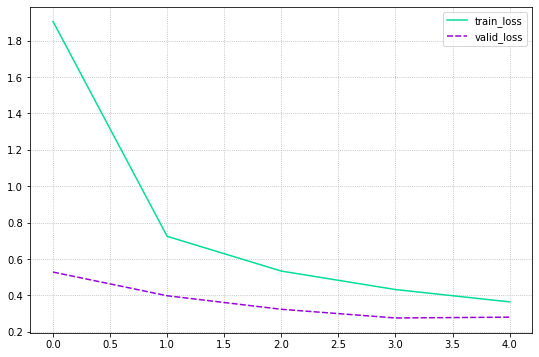

In [63]:
# Попробуем добавить нормализацию данных для наших изображений
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загружаем наши данные в DataLoader для подачи в нейросеть
train_data = Birds2(path, df_train, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
valid_data = Birds2(path, df_valid, transform=transform)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False, drop_last=True)

# Загружаем предобученную модель
model = shufflenet_v2_x0_5(pretrained=True)
# Изменение последнего слоя для 450 классов
num_classes = df['class_id'].nunique()
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
# Выбираем функцию потерь (вроде как CrossEntropy хороша для задач классификации)
criterion = nn.CrossEntropyLoss().to(device)
# Выбираем оптимизатор Adam, т.к. современный и активно используется
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
valid_losses = []
num_epochs = 5

for epoch in range(num_epochs):
    train_loss = 0.0
    for batch, labels in train_dataloader:
        # Закидываем наши данные на видеокарту
        batch, labels = batch.to(device), labels.to(device)
        model.train()
        optimizer.zero_grad()
        outputs = model(batch.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss = {loss.item():.4f}')
    
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch, labels in valid_dataloader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch.float())
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    print(f'Valid loss = {loss.item():.4f}')
    
    train_losses.append(train_loss / len(train_dataloader))
    valid_losses.append(valid_loss / len(valid_dataloader))
    
print('Training is finished')

torch.save(model, 'shufflenet_v2_x0_5_bird_classifier_5_epoch.pth')

combined_list = list(zip(train_losses, valid_losses))
losses = pd.DataFrame(combined_list, columns=['train_loss', 'valid_loss'])
losses.to_csv('shufflenet_v2_x0_5_Losses_5_epoch.csv', index=False)
f = plt.figure(figsize = (9, 6))
colors = ['#00DD99', '#9900DD']
sns.lineplot(data=losses, palette = colors)
plt.grid(ls = ':')
plt.show()
# Мы смогли довольно вовремя остановиться - ура!
# Предобученная модель показывает явно лучший результат, чем моя собственная архитектура ;(

6) Дать комментарии по результатам 3-5 пунктов, отрисовать графики -
3 балла

In [97]:
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, auc, precision_recall_fscore_support, accuracy_score
from sklearn.preprocessing import label_binarize

In [77]:
# Загрузка модели
model = torch.load('shufflenet_v2_x0_5_bird_classifier_5_epoch.pth')
model.eval() # Перевод модели в режим оценки

# Подготовка данных для предсказания
transform = Compose([
    Resize((224,224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ])
    
valid_data = Birds2(path, df_valid, transform=transform)
valid_dataloader = DataLoader(valid_data, batch_size=1, shuffle=False)

# Перевод данных на устройство, если доступно GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

pred_class = []    
# Выполнение предсказания
with torch.no_grad():
        for batch, labels in valid_dataloader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch.float())
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.cpu()
            pred_class.append(predicted.item())
 
#print(pred_class)

[0, 0, 131, 0, 9, 319, 1, 383, 440, 1, 2, 2, 2, 2, 2, 106, 100, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 41, 5, 5, 6, 6, 6, 338, 6, 7, 7, 241, 7, 7, 308, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 107, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 60, 19, 19, 19, 20, 20, 20, 20, 203, 21, 132, 21, 257, 132, 22, 22, 22, 22, 28, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 175, 401, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 176, 30, 30, 30, 30, 30, 31, 31, 31, 31, 278, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 34, 34, 315, 34, 391, 35, 35, 35, 35, 427, 36, 36, 36, 36, 36, 37, 37, 37, 37, 299, 38, 38, 95, 38, 38, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 44, 44, 44, 158, 45, 45, 45, 45, 45, 45, 46, 323, 46, 46, 46, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 50, 50, 50, 50,

In [82]:
true_class = df_valid['class_id'].tolist()
f1_macro = f1_score(true_class, pred_class, average='macro')
f1_micro = f1_score(true_class, pred_class, average='micro')
print("F1 метрика (макро):", f1_macro)
print("F1 метрика (микро):", f1_micro)
f1_weighted = f1_score(true_class, pred_class, average='weighted')
print("F1 метрика (среднее взвешенное):", f1_weighted)

F1 метрика (макро): 0.9170284653617988
F1 метрика (микро): 0.9195555555555556
F1 метрика (среднее взвешенное): 0.9170284653617988


In [99]:
# Вычисление точности, полноты, F-меры и поддержки для каждого класса
precision, recall, _ , _ = precision_recall_fscore_support(true_class, pred_class)
accuracy = accuracy_score(true_class, pred_class)
precision_aver = precision.mean()
recall_aver = recall.mean()

print('Accuracy:', accuracy)
print('Average Precision:', precision_aver)
print('Average Recall:', recall_aver)

Accuracy: 0.9195555555555556
Average Precision: 0.9323721340388007
Average Recall: 0.9195555555555556


/home/egor/miniconda3/envs/jupyter/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
# Возьмём последнюю из моих собственных моделей:

model = MyFirstArchiectureNN()
model.load_state_dict(torch.load('bird_classifier_5_epoch_norm.pth'))
model.eval() 

transform = Compose([
    Resize((224,224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ])
    
valid_data = Birds2(path, df_valid, transform=transform)
valid_dataloader = DataLoader(valid_data, batch_size=1, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

pred_class = []    
with torch.no_grad():
        for batch, labels in valid_dataloader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch.float())
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.cpu()
            pred_class.append(predicted.item())
 
#print(pred_class)

In [105]:
true_class = df_valid['class_id'].tolist()
f1_macro = f1_score(true_class, pred_class, average='macro')
f1_micro = f1_score(true_class, pred_class, average='micro')
f1_weighted = f1_score(true_class, pred_class, average='weighted')
print("F1 метрика (макро):", f1_macro)
print("F1 метрика (микро):", f1_micro)
print("F1 метрика (среднее взвешенное):", f1_weighted)

precision, recall, _ , _ = precision_recall_fscore_support(true_class, pred_class)
accuracy = accuracy_score(true_class, pred_class)
precision_aver = precision.mean()
recall_aver = recall.mean()

print('Accuracy:', accuracy)
print('Average Precision:', precision_aver)
print('Average Recall:', recall_aver)

# Моя собственная архитектура способна правильно определить менее половины изображений
# Итог: либо подбирать собственную архитектуру или же использовать уже готовые

F1 метрика (макро): 0.39749706076517227
F1 метрика (микро): 0.416
F1 метрика (среднее взвешенное): 0.3974970607651722
Accuracy: 0.416
Average Precision: 0.44177012802012805
Average Recall: 0.416


/home/egor/miniconda3/envs/jupyter/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
# Чтобы ужаснуться, возьмём самую первую модель
model = MyFirstArchiectureNN()
model.load_state_dict(torch.load('my_first_bird_classifier.pth'))
model.eval() 

transform = Compose([
    Resize((224,224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ])
    
valid_data = Birds2(path, df_valid, transform=transform)
valid_dataloader = DataLoader(valid_data, batch_size=1, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

pred_class = []    
with torch.no_grad():
        for batch, labels in valid_dataloader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch.float())
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.cpu()
            pred_class.append(predicted.item())
            
true_class = df_valid['class_id'].tolist()
f1_macro = f1_score(true_class, pred_class, average='macro')
f1_micro = f1_score(true_class, pred_class, average='micro')
f1_weighted = f1_score(true_class, pred_class, average='weighted')
print("F1 метрика (макро):", f1_macro)
print("F1 метрика (микро):", f1_micro)
print("F1 метрика (среднее взвешенное):", f1_weighted)

precision, recall, _ , _ = precision_recall_fscore_support(true_class, pred_class)
accuracy = accuracy_score(true_class, pred_class)
precision_aver = precision.mean()
recall_aver = recall.mean()

print('Accuracy:', accuracy)
print('Average Precision:', precision_aver)
print('Average Recall:', recall_aver)

# Лучше бы не смотрел...

F1 метрика (макро): 4.546749322405715e-05
F1 метрика (микро): 0.0013333333333333333
F1 метрика (среднее взвешенное): 4.546749322405714e-05
Accuracy: 0.0013333333333333333
Average Precision: 2.318141208679903e-05
Average Recall: 0.0013333333333333335


/home/egor/miniconda3/envs/jupyter/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
